In [1]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization

from keras.utils import np_utils
import numpy as np

from keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

In [13]:
random_seed = 42
np.random.seed(random_seed)
# Эту ячейку разбирать не нужно (необходима для корректной работы)
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history, plot_title, filename):
    label_accuracy = 'accuracy'
    label_val_accuracy = 'val_accuracy'
    xs = range(len(history.history[label_accuracy]))

    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.plot(xs, history.history[label_accuracy], label='train')
    plt.plot(xs, history.history[label_val_accuracy], label='validation')
    plt.legend(loc='lower left')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title(plot_title+', Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(xs, history.history['loss'], label='train')
    plt.plot(xs, history.history['val_loss'], label='validation')
    plt.legend(loc='upper left')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(plot_title+', Loss')

    #plt.tight_layout()
    #file_halper.save_figure(filename)
    plt.show()
    
import os, sys, inspect

class File_Helper:

    def __init__(self, really_save_files=True):
        self.really_save_files = really_save_files
        self.saved_output_dir = 'saved_output'
        self.input_data_dir = 'input_data'
        self.saved_models_dir = 'saved_models'
        self.saved_weights_dir = 'saved_weights'

    def get_input_file_path(self, filename):
        """Get the local path relative to the calling file's location to the input file"""
        return self.input_data_dir + '/' + filename

    def check_for_directory(self, directory, create_if_needed=True):
        """See if the directory exists. Optionally, create it."""
        path_exists = os.path.exists(directory)
        if path_exists:
            if not os.path.isdir(directory):
                raise Exception('Found '+directory+' but it is a file, not a directory')
                return False
            return True
        if create_if_needed:
            os.makedirs(directory)
        return path_exists

    def save_figure(self, filename):
        """Save the figure. Call this just before plt.show()."""
        if self.really_save_files and (filename != None):
            self.check_for_directory(self.saved_output_dir)
            plt.savefig(self.saved_output_dir+'/'+filename+'.png', dpi=300, bbox_inches='tight')

    def load_model_weights(self, model, weights_filename):
        """If the weights file exists, load from it and return True, else return False."""
        fullpath = self.saved_weights_dir+'/'+weights_filename+'.h5'
        if os.path.exists(fullpath):
            if os.path.isfile(fullpath):
                model.load_weights(fullpath)
                return True
        return False

    def save_model_weights(self, model, weights_filename):
        """Save the weights file in the saved weights directory."""
        if self.really_save_files and (weights_filename != None):
            self.check_for_directory(self.saved_weights_dir)
            fullpath = self.saved_weights_dir+'/'+weights_filename+'.h5'
            model.save_weights(fullpath)

    def load_model(self, model_filename):
        """If the model file exists, load from it and return the model, else return None."""
        fullpath = self.saved_models_dir+'/'+model_filename+'.h5'
        if os.path.exists(fullpath):
            if os.path.isfile(fullpath):
                model = load_model(fullpath)
                return model
        return None

    def save_model(self, model, model_filename):
        """Save the model file in the saved models directory."""
        if self.really_save_files and (model_filename != None):
            self.check_for_directory(self.saved_models_dir)
            fullpath = self.saved_models_dir+'/'+model_filename+'.h5'
            model.save(fullpath)
            
    def get_saved_output_dir(self):
        """Get the name of the directory where we save matplotlib output PNG files."""
        return self.saved_output_dir
    
    def get_input_data_dir(self):
        """Get the name of the directory where we look for input files."""
        return self.input_data_dir

    def get_saved_weights_dir(self):
        """Get the name of the directory where we read and write Keras weight files."""
        return self.saved_weights_dir

    def get_saved_models_dir(self):
        """Get the name of the directory where we read and write Keras model files."""
        return self.saved_models_dir
    


    # Make a File_Helper for saving and loading files.

save_files = True

current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
file_helper = File_Helper(save_files)

In [4]:
# load MNIST data and save sizes
(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width
image_size=(image_width, image_height)

# convert to floating-point
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)

data_range =  [-1,1]
use_scale = True
# scale data to range [-1, 1]
if(use_scale):
  X_train = np.interp(X_train, [0, 255], data_range)
  X_test = np.interp(X_test, [0, 255], data_range)

# save original y_train and y_test
original_y_train = y_train
original_y_test = y_test

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test))
y_train = to_categorical(y_train, num_classes=number_of_classes)
y_test = to_categorical(y_test, num_classes=number_of_classes)

# reshape sample data to 4D tensor using channels_last convention 
X_train = X_train.reshape(X_train.shape[0], image_height, image_width, 1)
X_test = X_test.reshape(X_test.shape[0], image_height, image_width, 1)

11493376/11490434 [==============================] - 0s 0us/step


#Создание моделей нейронных сетей

In [5]:
def make_simple_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (5, 5),
                     activation='relu', padding='same',
                     input_shape=(image_height, image_width, 1)))
    model.add(Flatten())
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

def make_bigger_cnn_model():
    model = Sequential()
    model.add(Conv2D(16, (5, 5), activation='relu', padding='same',
                     kernel_constraint=maxnorm(3),
                     input_shape=(image_height, image_width, 1)))
    model.add(Dropout(0.2))
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same',
                     kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same',
                     kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model
    
from keras.preprocessing import image as keras_image
import tensorflow as tf

def predict(filename, trained_model):
  use_keras = False

  if(use_keras):
    img = keras_image.load_img(
        filename, target_size=image_size, color_mode='grayscale', interpolation='bicubic'
    )
    img_array = keras_image.img_to_array(img, data_format="channels_last")
    img_array = keras_backend.cast_to_floatx(img_array)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  else:  
    import cv2
    import numpy as np

    img_array = cv2.imread(filename,0)
    img_array = cv2.resize(img_array, (28, 28))
    img_array = np.reshape(img_array, [1, 28, 28, 1])

  if(use_scale):
    img_array = np.interp(img_array, [0, 255], data_range)
  return trained_model.predict(img_array), trained_model.predict_classes(img_array), trained_model.predict_proba(img_array)

In [7]:
def run_model(model_maker, plot_title, filename):
    model = model_maker()
    np.random.seed(random_seed)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                     epochs=25, batch_size=10000)
    plot_accuracy_and_loss(history, plot_title, filename)
    
    return model, history

#Обучение нейронных сетей

Epoch 1/25
6/6 [==============================] - 1s 136ms/step - loss: 1.8239 - accuracy: 0.4203 - val_loss: 1.0922 - val_accuracy: 0.7871
Epoch 2/25
6/6 [==============================] - 1s 115ms/step - loss: 0.8719 - accuracy: 0.7906 - val_loss: 0.5879 - val_accuracy: 0.8589
Epoch 3/25
6/6 [==============================] - 1s 113ms/step - loss: 0.5224 - accuracy: 0.8618 - val_loss: 0.4163 - val_accuracy: 0.8844
Epoch 4/25
6/6 [==============================] - 1s 113ms/step - loss: 0.3943 - accuracy: 0.8850 - val_loss: 0.3372 - val_accuracy: 0.9033
Epoch 5/25
6/6 [==============================] - 1s 114ms/step - loss: 0.3310 - accuracy: 0.9034 - val_loss: 0.2947 - val_accuracy: 0.9146
Epoch 6/25
6/6 [==============================] - 1s 102ms/step - loss: 0.2897 - accuracy: 0.9165 - val_loss: 0.2606 - val_accuracy: 0.9259
Epoch 7/25
6/6 [==============================] - 1s 114ms/step - loss: 0.2576 - accuracy: 0.9265 - val_loss: 0.2356 - val_accuracy: 0.9351
Epoch 8/25
6/6 [====

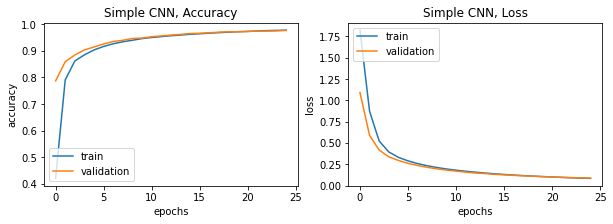

In [15]:
simple_model, simple_history = run_model(make_simple_cnn_model, 'Simple CNN', 'Simple-CNN-graphs')

Epoch 1/25
6/6 [==============================] - 1s 229ms/step - loss: 2.2314 - accuracy: 0.2486 - val_loss: 2.0331 - val_accuracy: 0.5666
Epoch 2/25
6/6 [==============================] - 1s 245ms/step - loss: 1.8134 - accuracy: 0.5851 - val_loss: 1.3382 - val_accuracy: 0.7082
Epoch 3/25
6/6 [==============================] - 1s 234ms/step - loss: 1.0981 - accuracy: 0.7219 - val_loss: 0.6779 - val_accuracy: 0.7962
Epoch 4/25
6/6 [==============================] - 1s 235ms/step - loss: 0.6430 - accuracy: 0.7973 - val_loss: 0.4754 - val_accuracy: 0.8483
Epoch 5/25
6/6 [==============================] - 1s 237ms/step - loss: 0.5033 - accuracy: 0.8447 - val_loss: 0.4219 - val_accuracy: 0.8772
Epoch 6/25
6/6 [==============================] - 1s 237ms/step - loss: 0.4323 - accuracy: 0.8717 - val_loss: 0.3598 - val_accuracy: 0.8974
Epoch 7/25
6/6 [==============================] - 1s 244ms/step - loss: 0.3708 - accuracy: 0.8892 - val_loss: 0.3021 - val_accuracy: 0.9104
Epoch 8/25
6/6 [====

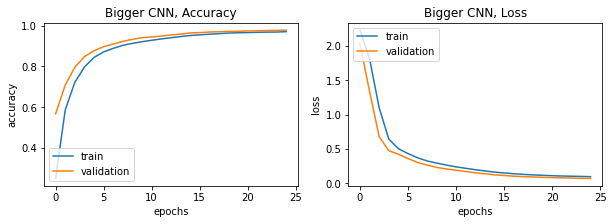

In [9]:
bigger_model, bigger_history = run_model(
    make_bigger_cnn_model, 'Bigger CNN', 'Bigger-CNN-graphs')

#Тестирование обученных моделей нейронных сетей

In [ ]:
!wget github.com/Uip1/it_cub_khv/blob/master/two.jpg
!wget github.com/Uip1/it_cub_khv/blob/master/three.jpg
!wget github.com/Uip1/it_cub_khv/blob/master/five.jpg

In [ ]:
filename = 'two.jpg'
predictions = predict(filename, bigger_model)
counter = 1
for score in predictions[0][0]:
  print(
      "This %s image is %.2f percent %d."
      % (filename, 100 * score, counter)
  )
  counter+=1

In [ ]:
filename = 'three.jpg'
predictions = predict(filename, bigger_model)
counter = 1
for score in predictions[0][0]:
  print(
      "This %s image is %.2f percent %d."
      % (filename, 100 * score, counter)
  )
  counter+=1

In [ ]:
filename = 'five.jpg'
predictions = predict(filename, bigger_model)
counter = 1
for score in predictions[0][0]:
  print(
      "This %s image is %.2f percent %d."
      % (filename, 100 * score, counter)
  )
  counter+=1

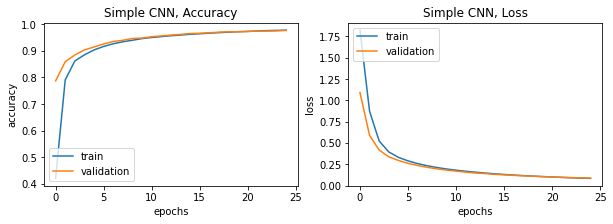

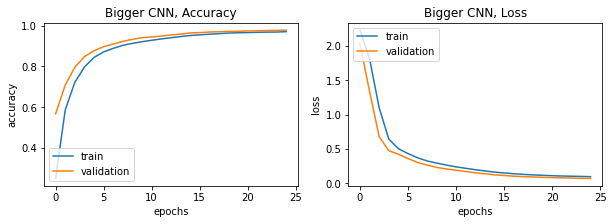

In [17]:
# get the plots by themselves
plot_accuracy_and_loss(simple_history, 'Simple CNN', 'Simple-CNN-graphs')
plot_accuracy_and_loss(bigger_history, 'Bigger CNN', 'Bigger-CNN-graphs')